In [1]:
#from __future__ import print_function
from scipy.misc import imsave
import numpy as np
import time
from keras import backend as K

from keras.models import model_from_json
import json

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
#load model
path = "/Users/augustus/python/CIFAR/models/vgg2_4.json"
json_object = open(path, "r")
loaded_json = json.loads(json_object.read())
json_object.close()

In [3]:
#load weights
model = model_from_json(loaded_json)
weights_path = "/Users/augustus/python/CIFAR/weights/vgg2_4_{val_acc:.2f}.hdf5"
model.load_weights(weights_path)

In [6]:
model.get_config()

[{'class_name': 'ZeroPadding2D',
  'config': {'batch_input_shape': (None, 32, 32, 3),
   'input_dtype': u'float32',
   'name': u'zeropadding2d_1',
   'padding': [1, 1],
   'trainable': True}},
 {'class_name': 'Convolution2D',
  'config': {'W_constraint': None,
   'W_regularizer': None,
   'activation': 'linear',
   'activity_regularizer': None,
   'b_constraint': None,
   'b_regularizer': None,
   'bias': True,
   'border_mode': u'valid',
   'dim_ordering': u'tf',
   'init': 'glorot_uniform',
   'name': u'convolution2d_1',
   'nb_col': 3,
   'nb_filter': 64,
   'nb_row': 3,
   'subsample': (1, 1),
   'trainable': True}},
 {'class_name': 'Activation',
  'config': {'activation': 'relu',
   'name': u'activation_1',
   'trainable': True}},
 {'class_name': 'MaxPooling2D',
  'config': {'border_mode': u'valid',
   'dim_ordering': u'tf',
   'name': u'maxpooling2d_1',
   'pool_size': (2, 2),
   'strides': (2, 2),
   'trainable': True}},
 {'class_name': 'ZeroPadding2D',
  'config': {'name': u'ze

In [4]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [9]:
# this is the placeholder for the input images
input_img = model.input

layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

model.input

<tf.Tensor 'zeropadding2d_input_1:0' shape=(?, 32, 32, 3) dtype=float32>

In [74]:
layer_name = "convolution2d_2"
img_width = 32
img_height = 32

kept_filters = []
for filter_index in range(0, 128):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_dim_ordering() == 'th':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_dim_ordering() == 'th':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(30):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

Processing filter 0
('Current loss value:', -91.912857)
Filter 0 processed in 1s
Processing filter 1
('Current loss value:', 100.76924)
('Current loss value:', 107.12588)
('Current loss value:', 113.57327)
('Current loss value:', 120.07455)
('Current loss value:', 126.60098)
('Current loss value:', 133.29053)
('Current loss value:', 140.01875)
('Current loss value:', 146.97812)
('Current loss value:', 154.08914)
('Current loss value:', 161.47006)
('Current loss value:', 169.19647)
('Current loss value:', 177.12411)
('Current loss value:', 185.3716)
('Current loss value:', 194.03011)
('Current loss value:', 203.05403)
('Current loss value:', 212.49495)
('Current loss value:', 222.20059)
('Current loss value:', 232.13098)
('Current loss value:', 242.38983)
('Current loss value:', 253.02032)
('Current loss value:', 263.96799)
('Current loss value:', 275.24506)
('Current loss value:', 286.76575)
('Current loss value:', 298.51263)
('Current loss value:', 310.53415)
('Current loss value:', 3

In [76]:
# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
len(kept_filters)

14

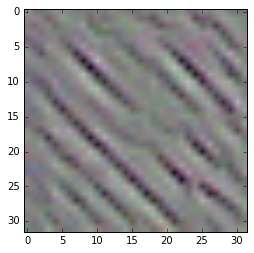

In [66]:
plt.imshow(kept_filters[1][0])

In [73]:
for i in range(len(kept_filters)):
    imsave("conv1_filter_" + str(i) + ".png", kept_filters[i][0])